# Exercise: Perform Object Localization With a CNN


In this exercise you'll be asked to recreate some of the features from the previous Jupyter notebook in order to create a neural network that performs Object Localization. You'll also be asked to use a custom loss function in order to improve the performance above and beyond the levels that the previous notebook achieves.


## Exercise Goals


This exercise is meant to help you:


* Read and prepare the Oxford pets dataset for processing with a Neural Network
* Implement a convolutional neural network that performs object localization.
* Implement a CNN that provides two predictions (classification and localization) by using the Keras [functional API](https://keras.io/getting-started/functional-api-guide/).
* Use a custom loss function in Keras.

## Exercise Notes


This exercise should take about 1 hour of actual work, but the training time for these models can be significant. You may wish to run training sessions overnight, during your lunch break, or just plan on leaving your computer while training your networks.
​
The provided Jupyter notebooks contain much of the information you need to complete this exercise. However, you should also expect to look up information from the Keras docs, the provided external reading material, and other sources. You are encouraged to search for information on your own.
​
Finally, this is not an exam. Correct answers are not provided. In fact, the exercise has enough ambiguity that many different answers will qualify as correct. You should be able to prove the correctness of your own answers using readily available tools—and in so doing you'll have learned quite a lot.


## The Exercise


Your goal is to build and train a neural network that performs single object localization using the Keras framework and the Oxford Pets dataset. You can leverage much of the code from the Object Localization Jupyter notebook, and you'll have to add and modify some code as well.

In [ ]:
# Required Libraries

from collections import namedtuple
import csv

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image, ImageOps

# XML parsing library comes with Python
import xml.etree.ElementTree as ET

### Part 1: Download the data
​
You can download the images and annotations for the Oxford Pets dataset from this website [https://www.robots.ox.ac.uk/~vgg/data/pets/](https://www.robots.ox.ac.uk/~vgg/data/pets/). The downloads section is near the top of the page. You will need to download both the "images" and "ground truth" datasets for this exercise.

In [ ]:
# Set your own project id here
PROJECT_ID = 'your-google-cloud-project'
from google.cloud import storage
storage_client = storage.Client(project=PROJECT_ID)

In [ ]:
# Oxford Pet dataset - "dataset" and the "groundtruth data"

PATH_TO_IMAGES = '../input/the-oxfordiiit-pet-dataset/images/images/'
PATH_TO_CLASS_LIST = '../input/the-oxfordiiit-pet-dataset/annotations/annotations/list.txt'
PATH_TO_XML_ANNOTATIONS = '../input/the-oxfordiiit-pet-dataset/annotations/annotations/xmls/'

# Change if you wish. 
TARGET_SIZE = (150, 150)

Here we visualise the pet images. Note that the images are of random shapes and sizes and the "image type" is a jpeg image file

<class 'PIL.JpegImagePlugin.JpegImageFile'>


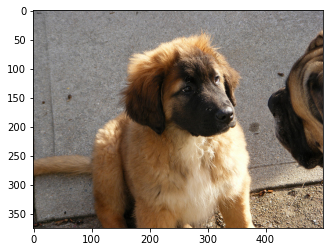

<class 'PIL.JpegImagePlugin.JpegImageFile'>


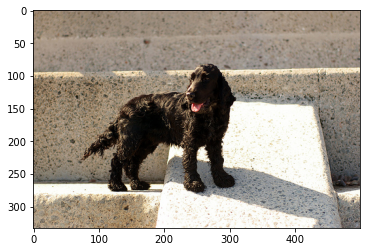

<class 'PIL.JpegImagePlugin.JpegImageFile'>


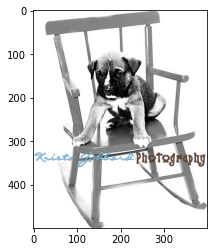

In [ ]:
from tensorflow.keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt
import os

c=0 # counter to generate sample images
for name in os.listdir(PATH_TO_IMAGES):
    if name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    image = keras_image.load_img(PATH_TO_IMAGES + name)
    print(type(image))
    plt.imshow(image)
    plt.show()
    c=c+1
    if c == 3:
      break

### Part 2: Parse and prepare the data
​
The dataset is described extensively on the website, as well as the Object Localization notebook in this same folder. Additionally, the notebook contains Python code that parses the raw data into a format that is ready for Keras to process. For each image you should:
​
1. Extract the image data and turn it into a Numpy array.
2. Ensure the image is square by padding it appropriately with black pixels.
3. Scale the image to an appropriate size as determined by the neural network you import (e.g. Xception, MobileNetV2, etc.)
4. Extract the bounding box from the XML file associated with each image.
5. Appropriately adjust the bounding box for any padding and resizing that the image received.
6. Extract the classification labels for each image.
7. Ignore images that do not have a bounding box in the provided annotations.


We shall solve this section in three parts

#### Part A

1. Extract the image data and turn it into a Numpy array.
2. Ensure the image is square by padding it appropriately with black pixels.
3. Scale the image to an appropriate size as determined by the neural network you import (e.g. Xception, MobileNetV2, etc.)

In [ ]:
from PIL import Image, ImageOps
import numpy as np

# Return an image padded to be square with the specified background size
# default is black.
def square_image(image, background_color=(0, 0 , 0)):
    width, height = image.size
    if width == height:
        result = image
    elif width > height:
        result = Image.new(image.mode, (width, width), background_color)
        result.paste(image, (0, (width - height) // 2))
    else:
        result = Image.new(image.mode, (height, height), background_color)
        result.paste(image, ((height - width) // 2, 0))

    return result

# This function takes an image path, loads the image using PIL
# and then returns version of that image which is padded to be
# square then resized to the specified target. Finally, we'll
# just return the image data as a numpy 3D array, which is better
# for the rest of our processing goals. 

# As shown above, keras relies on PIL under the hood already
# so this is a good way to go without adding dependencies. 
def load_maintain_aspect_ratio(input_image_path, target_size):
    image = Image.open(input_image_path)
    image = square_image(image).resize(target_size)
    
    # Get the image data as a numpy array.
    image = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    
    # Last thing: we're going to scale all the default (0-255) RGB
    # values to be floats from 0-1. If we do not do this in some cases
    # the generators we use below wrongly interpret the int's as floats
    # and clip values greater than 1. It's a strange bug you wouldn't expect
    # so it's better to just handle it here!
    return np.divide(image, 255)

<class 'numpy.ndarray'>


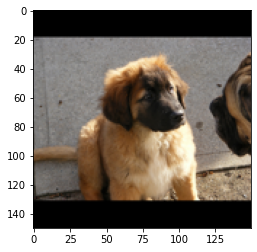

<class 'numpy.ndarray'>


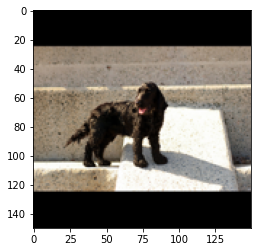

<class 'numpy.ndarray'>


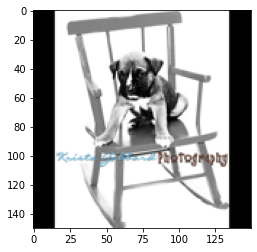

In [ ]:
c=0 # counter to generate sample images

for name in os.listdir(PATH_TO_IMAGES):
    if name.startswith('.'): continue 
    
    # Note the target_size parameter
    image = load_maintain_aspect_ratio(PATH_TO_IMAGES + name, target_size=TARGET_SIZE)
    print(type(image))
    plt.imshow(image)
    plt.show()
    c=c+1
    if c == 3:
      break

#### Part B

4. Extract the bounding box from the XML file associated with each image.
5. Appropriately adjust the bounding box for any padding and resizing that the image received.

We modify our previous function to accomodate these new requirements

In [ ]:
# Making the code easier to read.
BoundingBox = namedtuple('BoundingBox', 'xmin ymin xmax ymax')

# A function to read the XML and return (xmin, ymin, xmax, ymax)
def get_bounding_box(path_to_xml_annotation):
    tree = ET.parse(path_to_xml_annotation)
    root = tree.getroot()
    
    path_to_box = './object/bndbox/'
    xmin = int(root.find(path_to_box + "xmin").text)
    ymin = int(root.find(path_to_box + "ymin").text)
    xmax = int(root.find(path_to_box + "xmax").text)
    ymax = int(root.find(path_to_box + "ymax").text)

    return BoundingBox(xmin, ymin, xmax, ymax)

In [ ]:
# A function to reshape the images and appropriately transform
# the bounding box for that image. 

def resize_image_with_bounds(path_to_image, bounding_box=None, target_size=None):
    image = Image.open(path_to_image)
    width, height = image.size
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    # When we pad the image to square, we have to adjust all the bounding box
    # values by the amounts we added on the left or top. The "bonus" pads are
    # always done on the bottom and right so we can ignore them in terms of the box.

    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    
    if bounding_box is not None:
        new_xmin = bounding_box.xmin + w_pad
        new_xmax = bounding_box.xmax + w_pad
        new_ymin = bounding_box.ymin + h_pad
        new_ymax = bounding_box.ymax + h_pad
    
    # When we resize the image, it's by some scalar. We have to apply that 
    # scalar to the bounding box as well. We may lose a small amount of precision
    # when we do this, but not so much that it'll hurt our predictions

    if target_size is not None:

        # Note, width and height have changed due to the padding resize.
        # Update our notions so we get the scale factor right

        width, height = image.size

        image = image.resize(target_size)
        
        width_scale = target_size[0] / width
        height_scale = target_size[1] / height

        if bounding_box is not None:
            new_xmin = new_xmin * width_scale
            new_xmax = new_xmax * width_scale
            new_ymin = new_ymin * height_scale
            new_ymax = new_ymax * height_scale
    
    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    
    # Image data is a 3D array, 3 channels (RGB) of target_size.
    # RBG values are from 0-255. Later in this notebook we preprocess
    # those images with the MobileNetV2 preprocess input function. 
    
    if bounding_box is None:
        return image_data, None
    
    return (image_data, BoundingBox(new_xmin, new_ymin, new_xmax, new_ymax))

In [ ]:
# Given the relevant data from a row of the CSV return a reshaped image
# as well as it's transformed bounding box
def prepare_sample_from_name(sample_name):
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    path_to_xml = os.path.join(PATH_TO_XML_ANNOTATIONS, sample_name + '.xml')

    original_bounding_box = get_bounding_box(path_to_xml)
    image_data, bounding_box = resize_image_with_bounds(path_to_image, original_bounding_box, TARGET_SIZE)
    
    return (image_data, bounding_box)

In [ ]:
# Given the image data, plot the data with the bounding box.
# for testing/verification purposes. 

def plot_with_box(image_data, bounding_box, compare_box=None):
  
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_data)

    # Create a Rectangle patch. 
    rect_red = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
                             bounding_box.xmax - bounding_box.xmin,
                             bounding_box.ymax - bounding_box.ymin,
                             linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect_red)

    if compare_box is not None:
        rect_blue = patches.Rectangle((compare_box.xmin, compare_box.ymin),
                             compare_box.xmax - compare_box.xmin,
                             compare_box.ymax - compare_box.ymin,
                             linewidth=2, edgecolor='b', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect_blue)

    plt.show()

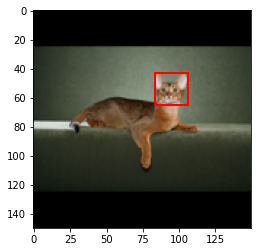

In [ ]:
# Visualizing progress thus far
sample_name = 'Abyssinian_1'

image, bounding_box = prepare_sample_from_name(sample_name)
plot_with_box(image, bounding_box)

#### Part C

6. Extract the classification labels for each image.
7. Ignore images that do not have a bounding box in the provided annotations.


In [ ]:
# Processing all samples 

processed_data = []

with open(PATH_TO_CLASS_LIST) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    
    for row in csv_reader:
        if row[0].startswith('#'): continue
        
        # Unpack for readability
        sample_name, class_id, species, breed_id = row

        # Not every image has a bounding box, some files are missing.
        # Using a try/except block to ignore such samples
        try:
            image, bounding_box = prepare_sample_from_name(sample_name)
        except FileNotFoundError:
            # we end up with 7349 samples.
            print(f'No annotations for {sample_name}: skipped.')
            continue
        
        # species - 1 so cat = 0 and dog = 1.
        # to make it easier to process
        data_tuple = (image, int(species) - 1, bounding_box)
        processed_data.append(data_tuple)
        
print(f'Processed {len(processed_data)} samples')

# Converting to a numpy array
processed_data = np.array(processed_data)

No annotations for Abyssinian_104: skipped.
No annotations for Bengal_111: skipped.
No annotations for samoyed_10: skipped.
No annotations for Bengal_175: skipped.
No annotations for Egyptian_Mau_14: skipped.
No annotations for Egyptian_Mau_156: skipped.
No annotations for Egyptian_Mau_186: skipped.
No annotations for Ragdoll_199: skipped.
No annotations for saint_bernard_15: skipped.
No annotations for Abyssinian_201: skipped.
No annotations for Abyssinian_202: skipped.
No annotations for Abyssinian_204: skipped.
No annotations for Abyssinian_205: skipped.
No annotations for Abyssinian_206: skipped.
No annotations for Abyssinian_207: skipped.
No annotations for Abyssinian_20: skipped.
No annotations for Abyssinian_210: skipped.
No annotations for Abyssinian_212: skipped.
No annotations for Abyssinian_213: skipped.
No annotations for Abyssinian_215: skipped.
No annotations for Abyssinian_216: skipped.
No annotations for Abyssinian_217: skipped.
No annotations for Abyssinian_219: skippe

No annotations for Bengal_198: skipped.
No annotations for Bengal_199: skipped.
No annotations for Bengal_19: skipped.
No annotations for Bengal_1: skipped.
No annotations for Bengal_200: skipped.
No annotations for Bengal_201: skipped.
No annotations for Bengal_20: skipped.
No annotations for Bengal_21: skipped.
No annotations for Bengal_22: skipped.
No annotations for Bengal_23: skipped.
No annotations for Bengal_24: skipped.
No annotations for Bengal_25: skipped.
No annotations for Bengal_26: skipped.
No annotations for Bengal_27: skipped.
No annotations for Bengal_28: skipped.
No annotations for Bengal_29: skipped.
No annotations for Bengal_2: skipped.
No annotations for Bengal_30: skipped.
No annotations for Bengal_31: skipped.
No annotations for Bengal_32: skipped.
No annotations for Bengal_33: skipped.
No annotations for Bengal_34: skipped.
No annotations for Bengal_35: skipped.
No annotations for Bengal_36: skipped.
No annotations for Bengal_37: skipped.
No annotations for Beng

No annotations for chihuahua_43: skipped.
No annotations for chihuahua_44: skipped.
No annotations for chihuahua_45: skipped.
No annotations for chihuahua_46: skipped.
No annotations for chihuahua_47: skipped.
No annotations for chihuahua_48: skipped.
No annotations for chihuahua_49: skipped.
No annotations for chihuahua_4: skipped.
No annotations for chihuahua_50: skipped.
No annotations for chihuahua_51: skipped.
No annotations for chihuahua_52: skipped.
No annotations for chihuahua_53: skipped.
No annotations for chihuahua_54: skipped.
No annotations for chihuahua_55: skipped.
No annotations for chihuahua_56: skipped.
No annotations for chihuahua_57: skipped.
No annotations for chihuahua_58: skipped.
No annotations for chihuahua_59: skipped.
No annotations for chihuahua_5: skipped.
No annotations for chihuahua_60: skipped.
No annotations for chihuahua_61: skipped.
No annotations for chihuahua_62: skipped.
No annotations for chihuahua_63: skipped.
No annotations for chihuahua_64: ski

No annotations for havanese_65: skipped.
No annotations for havanese_66: skipped.
No annotations for havanese_67: skipped.
No annotations for havanese_68: skipped.
No annotations for havanese_69: skipped.
No annotations for havanese_6: skipped.
No annotations for havanese_70: skipped.
No annotations for havanese_71: skipped.
No annotations for havanese_72: skipped.
No annotations for havanese_73: skipped.
No annotations for havanese_74: skipped.
No annotations for havanese_75: skipped.
No annotations for havanese_76: skipped.
No annotations for havanese_77: skipped.
No annotations for havanese_78: skipped.
No annotations for havanese_79: skipped.
No annotations for havanese_7: skipped.
No annotations for havanese_80: skipped.
No annotations for havanese_81: skipped.
No annotations for havanese_82: skipped.
No annotations for havanese_83: skipped.
No annotations for havanese_84: skipped.
No annotations for havanese_85: skipped.
No annotations for havanese_86: skipped.
No annotations for

No annotations for miniature_pinscher_98: skipped.
No annotations for miniature_pinscher_99: skipped.
No annotations for miniature_pinscher_9: skipped.
No annotations for newfoundland_191: skipped.
No annotations for newfoundland_192: skipped.
No annotations for newfoundland_193: skipped.
No annotations for newfoundland_194: skipped.
No annotations for newfoundland_195: skipped.
No annotations for newfoundland_196: skipped.
No annotations for newfoundland_197: skipped.
No annotations for newfoundland_198: skipped.
No annotations for newfoundland_199: skipped.
No annotations for newfoundland_19: skipped.
No annotations for newfoundland_1: skipped.
No annotations for newfoundland_200: skipped.
No annotations for newfoundland_20: skipped.
No annotations for newfoundland_21: skipped.
No annotations for newfoundland_22: skipped.
No annotations for newfoundland_23: skipped.
No annotations for newfoundland_24: skipped.
No annotations for newfoundland_25: skipped.
No annotations for newfoundla

No annotations for saint_bernard_45: skipped.
No annotations for saint_bernard_46: skipped.
No annotations for saint_bernard_47: skipped.
No annotations for saint_bernard_48: skipped.
No annotations for saint_bernard_49: skipped.
No annotations for saint_bernard_4: skipped.
No annotations for saint_bernard_50: skipped.
No annotations for saint_bernard_51: skipped.
No annotations for saint_bernard_52: skipped.
No annotations for saint_bernard_53: skipped.
No annotations for saint_bernard_54: skipped.
No annotations for saint_bernard_55: skipped.
No annotations for saint_bernard_56: skipped.
No annotations for saint_bernard_57: skipped.
No annotations for saint_bernard_58: skipped.
No annotations for saint_bernard_59: skipped.
No annotations for saint_bernard_5: skipped.
No annotations for saint_bernard_60: skipped.
No annotations for saint_bernard_61: skipped.
No annotations for saint_bernard_62: skipped.
No annotations for saint_bernard_63: skipped.
No annotations for saint_bernard_64:

No annotations for Siamese_85: skipped.
No annotations for Siamese_86: skipped.
No annotations for Siamese_87: skipped.
No annotations for Siamese_88: skipped.
No annotations for Siamese_89: skipped.
No annotations for Siamese_90: skipped.
No annotations for Siamese_91: skipped.
No annotations for Siamese_92: skipped.
No annotations for Siamese_93: skipped.
No annotations for Siamese_94: skipped.
No annotations for Siamese_95: skipped.
No annotations for Siamese_96: skipped.
No annotations for Siamese_97: skipped.
No annotations for Siamese_98: skipped.
No annotations for Siamese_99: skipped.
No annotations for Siamese_9: skipped.
No annotations for Sphynx_20: skipped.
No annotations for Sphynx_211: skipped.
No annotations for Sphynx_212: skipped.
No annotations for Sphynx_213: skipped.
No annotations for Sphynx_21: skipped.
No annotations for Sphynx_222: skipped.
No annotations for Sphynx_223: skipped.
No annotations for Sphynx_228: skipped.
No annotations for Sphynx_229: skipped.
No 

481 cat


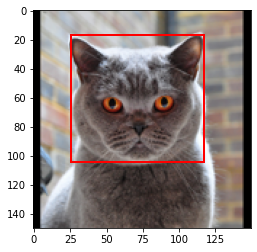

2917 dog


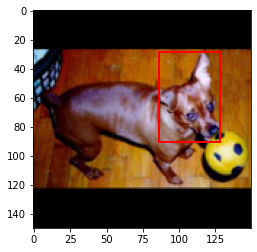

3194 cat


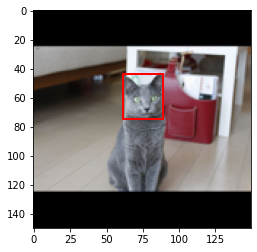

1334 cat


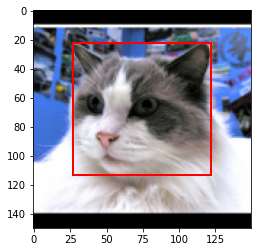

1614 cat


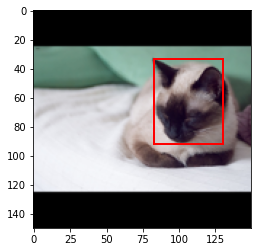

In [ ]:
# Random Spot Checking

for _ in range(5):
    i = np.random.randint(len(processed_data))
    image, species, bounding_box = processed_data[i]
    
    if species == 0:
        print(i, "cat")
    elif species == 1:
        print(i, "dog")
    else:
        print("ERROR DETECTED: Invalid species type")
        
    plot_with_box(image, bounding_box)

### Part 3: Import and prepare a CNN
​
Like in previous labs and exercises, we're applying transfer learning. Import a pre-trained network from Keras with `include_top=False`. Then, using the Keras functional API, give that network two prediction heads: one for classification and one for object localization.

In [ ]:
# Splitting the data and creating TWO separate 
# label groups to handle the classificaton and 
# bounding box predictions separately. 
x_train = []
y_class_train = []
y_box_train = []

x_validation = []
y_class_validation = []
y_box_validation = []

validation_split = 0.2

# We apply the preprocess_input function here:
for image, species, bounding_box in processed_data:
    if np.random.random() > validation_split:
        x_train.append(preprocess_input(image))
        y_class_train.append(species)
        y_box_train.append(bounding_box)
    else:
        x_validation.append(preprocess_input(image))
        y_class_validation.append(species)
        y_box_validation.append(bounding_box)
        
x_train = np.array(x_train)
y_class_train = np.array(y_class_train)
y_box_train = np.array(y_box_train)

x_validation = np.array(x_validation)
y_class_validation = np.array(y_class_validation)
y_box_validation = np.array(y_box_validation)

You'll have to decide which loss functions to use, and how to weight the predictions from each head during training at this point as well. In the notebook we used `binary_crossentropy` for the classifier, and `mse` for the localizer with weights of `1` and `800` respectively (those weights were chosen arbitrarily, but worked decently). You may wish to experiment with other options.

##### Model 1

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model1 = Model(inputs=[chopped_mobilenet.input], outputs=[localization_output,classification_output])

model1.summary()

In [ ]:
# okay, now when we compile the model we have to provide it with two loss functions
# one for each output layer.

model1.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['binary_crossentropy', 'mse'],
    loss_weights=[800, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

model1.fit(x_train, [y_box_train], 
          validation_data=(x_validation, [y_box_validation,classification_output]),
          epochs=3,
          verbose=True
)

##### Model 2

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model2 = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

model2.summary()

In [ ]:
model2.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[800, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

model2.fit(x_train, [y_class_train, y_box_train], 
          validation_data=(x_validation, [y_class_validation, y_box_validation]),
          epochs=3,
          verbose=True
)

##### Model 3

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model3 = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

model3.summary()

In [ ]:
model3.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['binary_crossentropy', 'mean_squared_logarithmic_error'],
    loss_weights=[800, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

model3.fit(x_train, [y_class_train, y_box_train], 
          validation_data=(x_validation, [y_class_validation, y_box_validation]),
          epochs=3,
          verbose=True
)

##### Model 4

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model4 = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

model4.summary()

In [ ]:
model4.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['binary_crossentropy', 'cosine_similarity'],
    loss_weights=[800, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

model4.fit(x_train, [y_class_train, y_box_train], 
          validation_data=(x_validation, [y_class_validation, y_box_validation]),
          epochs=3,
          verbose=True
)

##### Model 5

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model5 = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

model5.summary()

In [ ]:
model5.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['binary_crossentropy', 'mse'],
    loss_weights=[300, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

model5.fit(x_train, [y_class_train, y_box_train], 
          validation_data=(x_validation, [y_class_validation, y_box_validation]),
          epochs=3,
          verbose=True
)

##### Model 6

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model6 = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

model6.summary()

In [ ]:
model6.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['binary_crossentropy', 'mse'],
    loss_weights=[500, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

model6.fit(x_train, [y_class_train, y_box_train], 
          validation_data=(x_validation, [y_class_validation, y_box_validation]),
          epochs=3,
          verbose=True
)

##### Observations

Seeing the accuracies of the above models by varying the classifier and localization loss as well as the loss weights, we choose model 4 for our final analysis - loss = binary cross entropy and mean squared logarithmic error

### Part 4: Train and evaluate the model
​
Training the model may take a long time, particularly if you'd like to do several epochs. Once you've trained the network evaluate its performance by looking at the loss and accuracy metrics, as well as looking at several of your networks predictions. Code for visualizing the networks predicted bounding boxes and the ground truth from in the dataset is provided in the Object Localization Jupyter notebook.

In [ ]:
#building the final model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

modelfinal = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

modelfinal.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________

In [ ]:
#training over 20 epochs

modelfinal.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['binary_crossentropy', 'mean_squared_logarithmic_error'],
    loss_weights=[800, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

modelfinal.fit(x_train, [y_class_train, y_box_train], 
          validation_data=(x_validation, [y_class_validation, y_box_validation]),
          epochs=20,
          verbose=True
)

Epoch 1/20
92/92 [==============================] - 8s 86ms/step - loss: 292.2065 - dense_4_loss: 0.3647 - dense_5_loss: 0.4590 - dense_4_accuracy: 0.8321 - dense_5_accuracy: 0.7230 - val_loss: 543.9471 - val_dense_4_loss: 0.6796 - val_dense_5_loss: 0.2619 - val_dense_4_accuracy: 0.8126 - val_dense_5_accuracy: 0.7724
Epoch 2/20
92/92 [==============================] - 7s 74ms/step - loss: 89.7633 - dense_4_loss: 0.1120 - dense_5_loss: 0.1588 - dense_4_accuracy: 0.9607 - dense_5_accuracy: 0.8010 - val_loss: 1328.4523 - val_dense_4_loss: 1.6602 - val_dense_5_loss: 0.2773 - val_dense_4_accuracy: 0.7564 - val_dense_5_accuracy: 0.7952
Epoch 3/20
92/92 [==============================] - 7s 75ms/step - loss: 39.5621 - dense_4_loss: 0.0493 - dense_5_loss: 0.1464 - dense_4_accuracy: 0.9826 - dense_5_accuracy: 0.8057 - val_loss: 3300.7998 - val_dense_4_loss: 4.1257 - val_dense_5_loss: 0.2668 - val_dense_4_accuracy: 0.6948 - val_dense_5_accuracy: 0.8046
Epoch 4/20
92/92 [=========================

Calculating our IoU values corresponding to the predictions on validation data

Called it a dog
IoU value =  0.21860601043971273


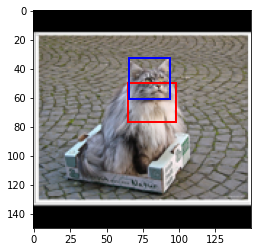

Called it a dog
IoU value =  0.08187490932195376


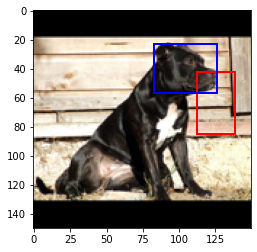

Called it a dog
IoU value =  0.5018553461061568


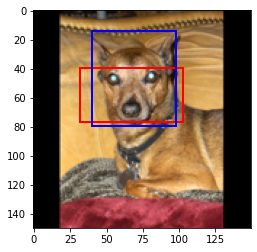

In [ ]:
# Fetching the non mobile-net processed images so we can actually see them

intersection = 0.0
union = 0.0

for _ in range(3):
    i = np.random.randint(len(processed_data))
    img, species, true_bounding_box = processed_data[i]

    pred = modelfinal.predict(np.array([preprocess_input(img)]))
    
    if pred[0][0] < .5:
        print("Called it a Cat")
    else:
        print("Called it a dog")
        
    # printing IoU values
        
    l = min(float(pred[1][0][2]),float(true_bounding_box.xmax)) - max(float(pred[1][0][0]),float(true_bounding_box.xmin))
    b = min(float(pred[1][0][3]),float(true_bounding_box.ymax)) - max(float(pred[1][0][1]),float(true_bounding_box.ymin))
       
    if l<0 or b<0:
        intersection = 0
    else:
        intersection = l*b
        
    union = (float(pred[1][0][2])-float(pred[1][0][0]))*(float(pred[1][0][3])-float(pred[1][0][1])) + (float(true_bounding_box.xmax)-float(true_bounding_box.xmin))*(float(true_bounding_box.ymax)-float(true_bounding_box.ymin)) - intersection

    iou = intersection/union
    print("IoU value = ",iou)

    # Thre true box is in blue, predicted in red
    plot_with_box(img, BoundingBox(*pred[1][0]), true_bounding_box)

Generalizing the IoU value for the current epoch value = 20 corresponding to classification accuracy of 0.8942 and localisation accuracy of 0.7671

In [ ]:
intersection = 0.0
union = 0.0
t = 0.0

for _ in range(len(processed_data)):
    i = _
    img, species, true_bounding_box = processed_data[i]

    pred = modelfinal.predict(np.array([preprocess_input(img)]))
    
    #if pred[0][0] < .5:
        #print("Called it a Cat")
    #else:
        #print("Called it a dog")
        
    # printing IoU values
        
    l = min(float(pred[1][0][2]),float(true_bounding_box.xmax)) - max(float(pred[1][0][0]),float(true_bounding_box.xmin))
    b = min(float(pred[1][0][3]),float(true_bounding_box.ymax)) - max(float(pred[1][0][1]),float(true_bounding_box.ymin))
       
    if l<0 or b<0:
        intersection = 0
    else:
        intersection = l*b
        
    union = (float(pred[1][0][2])-float(pred[1][0][0]))*(float(pred[1][0][3])-float(pred[1][0][1])) + (float(true_bounding_box.xmax)-float(true_bounding_box.xmin))*(float(true_bounding_box.ymax)-float(true_bounding_box.ymin)) - intersection

    #individual IoU values
    iou = intersection/union
    
    #total sum of IoUs
    t = t + iou
    
# Average IoU value for the current epoch
    
print("Average IoU = ", t/len(processed_data))

    # Thre true box is in blue, predicted in red
    #plot_with_box(img, BoundingBox(*pred[1][0]), true_bounding_box)

Average IoU =  0.4044941891499996


We could thus vary number avergae IoU per epoch by looping on predictions obtained on number of epochs. This part was not executed due to processing problems and limitations of online colab/kaggle platforms

../input/the-oxfordiiit-pet-dataset/images/images/Ragdoll_199.jpg
Called it a dog


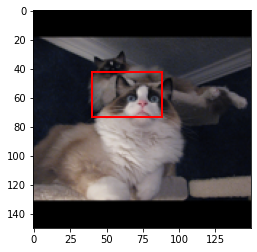

../input/the-oxfordiiit-pet-dataset/images/images/saint_bernard_15.jpg
Called it a dog


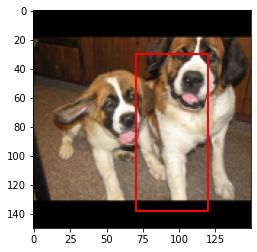

../input/the-oxfordiiit-pet-dataset/images/images/Abyssinian_201.jpg
Called it a dog


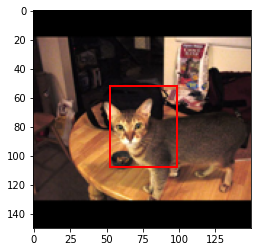

../input/the-oxfordiiit-pet-dataset/images/images/beagle_202.jpg
Called it a dog


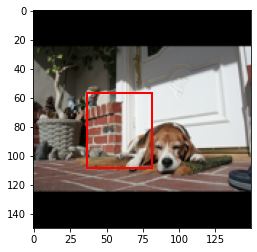

In [ ]:
# Performance on images that we didn't have the bounding boxes for

unknown_samples = [
    'Ragdoll_199',
    'saint_bernard_15',
    'Abyssinian_201',
    'beagle_202'
]

for sample_name in unknown_samples:
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    print(path_to_image)
    img, _ = resize_image_with_bounds(path_to_image, target_size=TARGET_SIZE)
    pred = modelfinal.predict(np.array([preprocess_input(img)]))
    
    if pred[0][0] < .5:
        print("Called it a Cat")
    else:
        print("Called it a dog")

    # We have no idea what the "true bounding box" should be
    # but we can decide if we think our network is doing okay
    plot_with_box(img, BoundingBox(*pred[1][0]))

### Challenge Opportunities


##### Challenge Opportunity 1

**Challenge Opportunity** in the provided notebook, we only classify images as being of a "dog" or "cat" but the provided dataset has more detailed labels for the breed of each dog or cat. You can choose to implement a simpler "dog or cat" classifier, as done in the provided notebook, or make your network predict the breed. If you go for breed then your classification head will need a node for each possible breed, which means you will also not want to use `binary_crossentropy` as your loss function, since it is designed for binary classifiers.

In [ ]:
# Processing all samples w.r.t breed ids

processed_data_breed = []

with open(PATH_TO_CLASS_LIST) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    
    for row in csv_reader:
        if row[0].startswith('#'): continue
        
        # Unpack for readability
        sample_name, class_id, species, breed_id = row

        # Not every image has a bounding box, some files are missing.
        # Using a try/except block to ignore such samples
        try:
            image, bounding_box = prepare_sample_from_name(sample_name)
        except FileNotFoundError:
            # we end up with 7349 samples.
            print(f'No annotations for {sample_name}: skipped.')
            continue
        
        # species - 1 so cat = 0 and dog = 1 to make it easier to process
        # breed 1-25 = cat, 26-37 = dog
        data_quad = (image, int(species)-1, int(class_id), bounding_box)
        
        processed_data_breed.append(data_quad)
        
print(f'Processed {len(processed_data_breed)} samples')

# Converting to a numpy array
processed_data_breed = np.array(processed_data_breed)

In [ ]:
# Random Spot Checking

for _ in range(5):
    i = np.random.randint(len(processed_data_breed))
    image, species, class_id, bounding_box = processed_data_breed[i]
    
    if species == 0:
        print(i, "breed num of cat =", class_id)
    elif species == 1:
        print(i, "breed num of dog =", class_id)
    else:
        print("ERROR DETECTED: Invalid species type")
        
    plot_with_box(image, bounding_box)

In [ ]:
# Replacing species by class_id for breed reference
# 0-25 = dogs, 0-12 = cats

x1_train = []
y1_class_train = []
y1_box_train = []

x1_validation = []
y1_class_validation = []
y1_box_validation = []

validation_split = 0.2

# We apply the preprocess_input function here:
for image, species, breed_id, bounding_box in processed_data_breed:
    if np.random.random() > validation_split:
        x1_train.append(preprocess_input(image))
        y1_class_train.append(class_id)
        y1_box_train.append(bounding_box)
    else:
        x1_validation.append(preprocess_input(image))
        y1_class_validation.append(class_id)
        y1_box_validation.append(bounding_box)
        
x1_train = np.array(x1_train)
y1_class_train = np.array(y1_class_train)
y1_box_train = np.array(y1_box_train)

x1_validation = np.array(x1_validation)
y1_class_validation = np.array(y1_class_validation)
y1_box_validation = np.array(y1_box_validation)

In [ ]:
print(y1_class_train[0]) # breed reference number
print(y1_class_validation[0]) 

In [ ]:
# one-hot-encoding

from tensorflow.keras.utils import to_categorical

y1_class_train = to_categorical(y1_class_train,37) #turning labels into arrays
y1_class_validation = to_categorical(y1_class_validation,37)


In [ ]:
# checking the encoding

print(y1_class_train[0]) 
print(y1_class_validation[0]) 

In [ ]:
# Applying Transfer Learning by applying a pretrained model with include_top=False
# Choice of model - MobileNetV2
# We replace the single unit output of species classification to 37 units for breeds

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=37, activation='sigmoid')(classification_output) # changing to 37 units for each breed

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

model.summary()

In [ ]:
# when we compile the model we have to provide it with two loss functions
# one for each output layer. We use categorical cross entropy here instead of binary
# cross entropy as we now have 37 possible outputs

model.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[1000, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

model.fit(x1_train, [y1_class_train, y1_box_train], 
          validation_data=(x1_validation, [y1_class_validation, y1_box_validation]),
          epochs=10,
          verbose=True
)

##### Challenge Opportunity 2

**Challenge Opportunity** in the provided notebook we have our network predict the pixel position of the bounding box. Better performance can often be achieved by normalizing these values between 0-1. In other words, for each of the four points in our bounding box, have your model predict those positions as a scalar relative to the image size, rather than absolute pixel position. Normalizing these outputs will require you to change the way we process the image and XML input data.

In [ ]:
print(bounding_box) # format of coordinates of box

In [ ]:
# A function to reshape the images and appropriately transform
# the bounding box for that image. 

def resize_image_with_bounds_norm(path_to_image, bounding_box=None, target_size=None):
    image = Image.open(path_to_image)
    width, height = image.size
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    # When we pad the image to square, we have to adjust all the bounding box
    # values by the amounts we added on the left or top. The "bonus" pads are
    # always done on the bottom and right so we can ignore them in terms of the box.

    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    
    if bounding_box is not None:
        new_xmin = bounding_box.xmin + w_pad
        new_xmax = bounding_box.xmax + w_pad
        new_ymin = bounding_box.ymin + h_pad
        new_ymax = bounding_box.ymax + h_pad
    
    # When we resize the image, it's by some scalar. We have to apply that 
    # scalar to the bounding box as well. We may lose a small amount of precision
    # when we do this, but not so much that it'll hurt our predictions

    if target_size is not None:

        # Note, width and height have changed due to the padding resize.
        # Update our notions so we get the scale factor right

        width, height = image.size

        image = image.resize(target_size)
        
        width_scale = target_size[0] / width
        height_scale = target_size[1] / height

        if bounding_box is not None:
            new_xmin = new_xmin * width_scale
            new_xmax = new_xmax * width_scale
            new_ymin = new_ymin * height_scale
            new_ymax = new_ymax * height_scale
    
    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    
    # Image data is a 3D array, 3 channels (RGB) of target_size.
    # RBG values are from 0-255. Later in this notebook we preprocess
    # those images with the MobileNetV2 preprocess input function. 
    
    if bounding_box is None:
        return image_data, None
    
    #normalizing coordinates
    return (image_data, BoundingBox(new_xmin/int(TARGET_SIZE[0]), new_ymin/int(TARGET_SIZE[1]), new_xmax/int(TARGET_SIZE[0]), new_ymax/int(TARGET_SIZE[1])))

In [ ]:
# Given the relevant data from a row of the CSV return a reshaped image
# as well as it's transformed bounding box

def prepare_sample_from_name_norm(sample_name):
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    path_to_xml = os.path.join(PATH_TO_XML_ANNOTATIONS, sample_name + '.xml')

    original_bounding_box = get_bounding_box(path_to_xml)
    image_data, bounding_box = resize_image_with_bounds_norm(path_to_image, original_bounding_box, TARGET_SIZE)
    
    return (image_data, bounding_box)

In [ ]:
# Processing all samples and normalizing bounding box values

processed_data_box = []

with open(PATH_TO_CLASS_LIST) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    
    for row in csv_reader:
        if row[0].startswith('#'): continue
        
        # Unpack for readability
        sample_name, class_id, species, breed_id = row

        # Not every image has a bounding box, some files are missing.
        # Using a try/except block to ignore such samples
        try:
            image, bounding_box = prepare_sample_from_name_norm(sample_name)
        except FileNotFoundError:
            # we end up with 7349 samples.
            print(f'No annotations for {sample_name}: skipped.')
            continue
        
        # species - 1 so cat = 0 and dog = 1.
        # to make it easier to process
        data_tuple = (image, int(species) - 1, bounding_box)
        processed_data_box.append(data_tuple)
        
print(f'Processed {len(processed_data_box)} samples')

# Converting to a numpy array
processed_data_box = np.array(processed_data_box)

In [ ]:
# check point. Note that pre processing performed significantly fatser here

print(bounding_box)

We have thus normalized our coordinates

In [ ]:
# expanding normalization for plotting

def plot_with_box(image_data, bounding_box, compare_box=None):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_data)

    # Create a Rectangle patch. 
    rect_red = patches.Rectangle((bounding_box.xmin*int(TARGET_SIZE[0]), bounding_box.ymin*int(TARGET_SIZE[1])),
                             bounding_box.xmax*int(TARGET_SIZE[0]) - bounding_box.xmin*int(TARGET_SIZE[1]),
                             bounding_box.ymax*int(TARGET_SIZE[0]) - bounding_box.ymin*int(TARGET_SIZE[1]),
                             linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect_red)

    if compare_box is not None:
        rect_blue = patches.Rectangle((compare_box.xmin*int(TARGET_SIZE[0]), compare_box.ymin*int(TARGET_SIZE[1])),
                             compare_box.xmax*int(TARGET_SIZE[0]) - compare_box.xmin*int(TARGET_SIZE[1]),
                             compare_box.ymax*int(TARGET_SIZE[0]) - compare_box.ymin*int(TARGET_SIZE[1]),
                             linewidth=2, edgecolor='b', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect_blue)

    plt.show()

In [ ]:
# Random Spot Checking

for _ in range(5):
    i = np.random.randint(len(processed_data_box))
    image, species, bounding_box = processed_data_box[i]
    
    if species == 0:
        print(i, "cat")
    elif species == 1:
        print(i, "dog")
    else:
        print("ERROR DETECTED: Invalid species type")
        
    plot_with_box(image, bounding_box)

We can thus transition from normalized version to original one smoothly

In [ ]:
# Replacing species by class_id for breed reference

x2_train = []
y2_class_train = []
y2_box_train = []

x2_validation = []
y2_class_validation = []
y2_box_validation = []

validation_split = 0.2

# We apply the preprocess_input function here:
for image, species, bounding_box in processed_data_box:
    if np.random.random() > validation_split:
        x2_train.append(preprocess_input(image))
        y2_class_train.append(species)
        y2_box_train.append(bounding_box)
    else:
        x2_validation.append(preprocess_input(image))
        y2_class_validation.append(species)
        y2_box_validation.append(bounding_box)
        
x2_train = np.array(x2_train)
y2_class_train = np.array(y2_class_train)
y2_box_train = np.array(y2_box_train)

x2_validation = np.array(x2_validation)
y2_class_validation = np.array(y2_class_validation)
y2_box_validation = np.array(y2_box_validation)

In [ ]:
# check to see if data is normalized

print(y2_box_train[2])
print(y2_box_validation[2])

In [ ]:
# Applying Transfer Learning by applying a pretrained model with include_top=False
# Choice of model - MobileNetV2
# We replace the single unit output of species classification to 37 units for breeds

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most 
# likely learned the highest level features specific to imagenet 
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model_norm = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

model_norm.summary()

In [ ]:


model_norm.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[1000, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

model_norm.fit(x2_train, [y2_class_train, y2_box_train], 
          validation_data=(x2_validation, [y2_class_validation, y2_box_validation]),
          epochs=10,
          verbose=True
)

We see that our model doesn't work. I have tried to redo this many times but am unable to find the flaw. Kindly do let me know.

##### Challenge Opportunity 3

**Challenge Opportunity** Accuracy is one popular metric for judging the performance of a classifier. [Intersection over Union](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) is a popular metric for judging the accuracy of an object localization model. Consider implementing a custom metric to compute the intersection over union as a validation metric for your model, and plot its change over time during training alongside accuracy and the `mse` loss.

# Evaluation Metric

We use intersection over union metric (IoU) to evaluate the accuracy of the predicted bounding boxes. Visually, 


Mathematically, this is evaluated as 

$$IoU(b_{A}, b_{B}) = \frac{b_A \cap b_B}{b_A \cup b_B} $$

where, 

bA = area of predicted box

bB = area of ground truth box

Refer part 4 above before Challenge Opportunities section